# Hourly Energy Consumption - Part 2

This notebook includes examples of the following time series forecasting methods:
* Simple Exponential Smoothing
* Triple Exponential Smoothing (Holt-Winters)
* LSTM
* Prophet

### Import Libraries & Load Data

In [1]:
# Load Modules
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Set Plotting Styles
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (18, 18)

# Load Data
duq_df = pd.read_csv('data/DUQ_hourly.csv', index_col=[0], parse_dates=[0])

# Sort Data
duq_df.sort_index(inplace=True)

### Manage Duplicate Measurements

In [2]:
# Identify Duplicate Indices
duplicate_index = duq_df[duq_df.index.duplicated()]
duq_df.loc[duplicate_index.index.values, :]

,DUQ_MW
Datetime,
2014-11-02 02:00:00,1272.0
2014-11-02 02:00:00,1240.0
2015-11-01 02:00:00,1113.0
2015-11-01 02:00:00,1138.0
2016-11-06 02:00:00,1121.0
2016-11-06 02:00:00,1107.0
2017-11-05 02:00:00,1131.0
2017-11-05 02:00:00,1105.0


In [3]:
# Replace Duplicates with Mean Value
duq_df = duq_df.groupby('Datetime').agg(np.mean)

# Set DatetimeIndex Frequency
duq_df = duq_df.asfreq('H')

### Impute Missing Values

In [4]:
# Determine # of Missing Values
print('# of Missing DUQ_MW Values: {}'.format(len(duq_df[duq_df['DUQ_MW'].isna()])))

# of Missing DUQ_MW Values: 24


In [5]:
# Impute Missing Values
duq_df['DUQ_MW'] = duq_df['DUQ_MW'].interpolate(limit_area='inside', limit=None)

### Create Features

In [6]:
def create_features(df):
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df.drop('Date', axis=1, inplace=True)
    return df

duq_df = create_features(duq_df)

In [7]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from datetime import datetime

train_series = duq_df.loc[(duq_df.index >= datetime(2016, 1, 1)) & (duq_df.index < datetime(2018, 8, 1)), 'DUQ_MW']
test_series = duq_df.loc[(duq_df.index >= datetime(2018, 8, 1)), 'DUQ_MW']

# Simple Exponential Smoothing

In [8]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [9]:
SES_model = SimpleExpSmoothing(train_series, initialization_method='estimated').fit()
preds = SES_model.forecast(steps=len(test_series))
error = mean_squared_error(test_series, preds)

print('MSE: %.3f' % error)

MSE: 57205.995


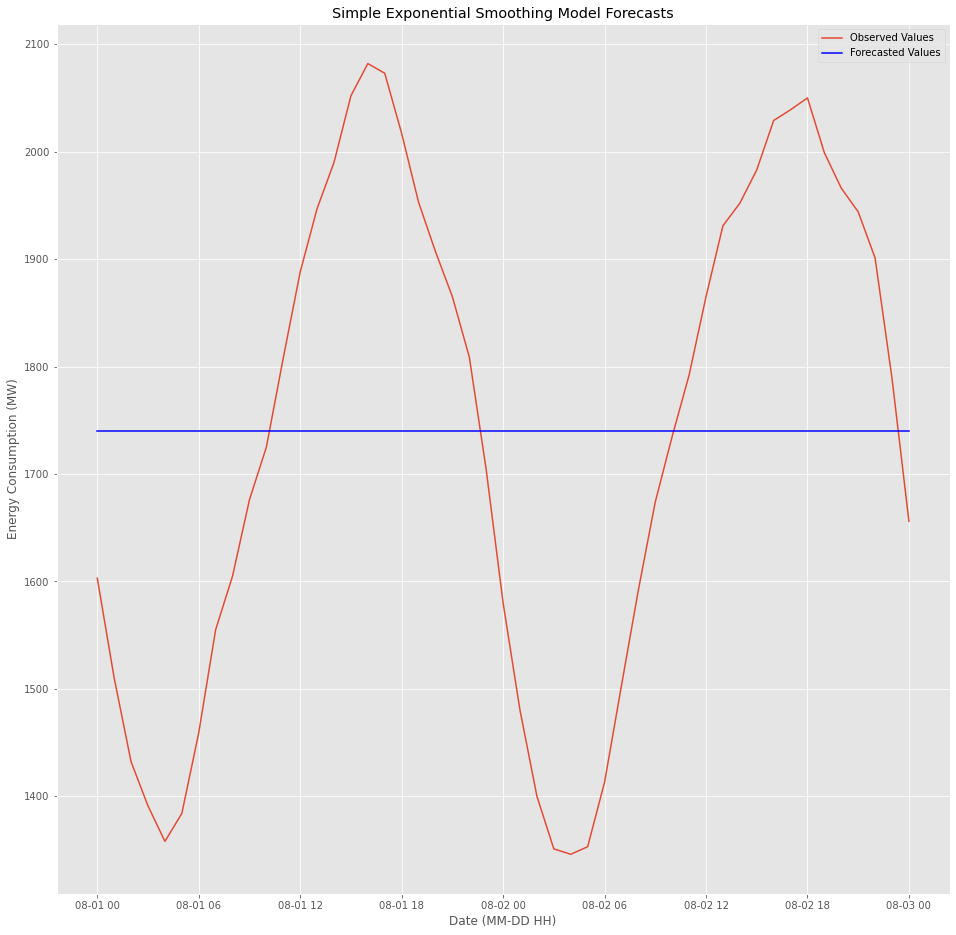

In [10]:
fig, axes = plt.subplots(figsize=(16,16))

axes.plot(test_series, label='Observed Values')
axes.plot(preds, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Simple Exponential Smoothing Model Forecasts')
plt.savefig('images/SES-forecasts.png')

# Triple Exponential Smoothing (Holt-Winters)
### Seasonal Periods = 24

In [ ]:
HW_model = ExponentialSmoothing(train_series.values, seasonal_periods=24, trend='add', seasonal='mul')
HW_model_fit = HW_model.fit()

HW_preds = HW_model_fit.forecast(steps=len(test_series))
HW_preds_series = pd.Series(HW_preds, index=test_series.index)

error = mean_squared_error(test_series, HW_preds_series)
print('MSE: %.3f' % error)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

axes.plot(test_series, label='Observed Values')
axes.plot(HW_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Holt-Winters Model Forecasts (Seasonal Periods = 24)')
plt.savefig('images/HW-forecasts-24.png')

### Seasonal Periods = 24 * 365

In [ ]:
# Caution: training may take >24 hrs

# HW_model = ExponentialSmoothing(train_series.values, seasonal_periods=24*365, trend='add', seasonal='mul')
# HW_model_fit = HW_model.fit()

# HW_preds = HW_model_fit.forecast(steps=len(test_series))
# HW_preds_series = pd.Series(HW_preds, index=test_series.index)

# error = mean_squared_error(test_series, HW_preds_series)
# print('MSE: %.3f' % error)

In [ ]:
# fig, axes = plt.subplots(figsize=(16,16))

# axes.plot(test_series, label='Observed Values')
# axes.plot(HW_preds_series, color='blue', label='Forecasted Values')
# plt.xlabel('Date (MM-DD HH)')
# plt.ylabel('Energy Consumption (MW)')
# axes.title.set_text('Holt-Winters Model Forecasts (Seasonal Periods = 24 * 365)')
# plt.savefig('images/HW-forecasts-24365.png')

# LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

np.random.seed(73)

# Apply MinMaxScaler to training and test data. Fit to training data, use to transform train + test

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_values = scaler.fit_transform(train_series.values.reshape(-1,1))
train_series_scaled = pd.Series(data=scaled_train_values.reshape(1,-1)[0], index=train_series.index)

# Create TimeseriesGenerator using training data and selected hyperparameters

n_input = 24
n_features= 1
sampling_rate = 1
stride = 1
batch_size = 1

train_generator = TimeseriesGenerator(scaled_train_values, 
                                      scaled_train_values, 
                                      length=n_input,
                                      sampling_rate=sampling_rate,
                                      stride=stride,
                                      batch_size=batch_size)

# Build and fit model

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_generator, epochs=80)

# Generate predictions

lstm_preds = []

batch = scaled_train_values[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_series)):
    pred = model.predict(current_batch)[0]
    lstm_preds.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)
    
# Evaluate performance
    
lstm_preds = scaler.inverse_transform(lstm_preds)
lstm_preds = [item for sublist in lstm_preds for item in sublist]
    
test_score = mean_squared_error(test_series.values, lstm_preds)
print(test_score)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

LSTM_preds_series = pd.Series(lstm_preds, index=test_series.index)

axes.plot(test_series, label='Observed Values')
axes.plot(LSTM_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('LSTM Forecasts')
plt.savefig('images/LSTM-forecasts.png')

# Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
train_df = pd.DataFrame(train_series).reset_index(drop=False)
train_df.columns = ['ds', 'y']

In [ ]:
prophet_model = Prophet()
prophet_model.fit(train_df)

future = prophet_model.make_future_dataframe(periods=len(test_series), freq='H')
forecast = prophet_model.predict(future)

In [ ]:
prophet_preds = forecast['yhat'][-49:].values

In [ ]:
test_score = mean_squared_error(test_series.values, prophet_preds)
print(test_score)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

prophet_preds_series = pd.Series(prophet_preds, index=test_series.index)

axes.plot(test_series, label='Observed Values')
axes.plot(prophet_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')

## Add Holiday Effects

In [ ]:
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='US')

prophet_model.fit(train_df)
future = prophet_model.make_future_dataframe(periods=len(test_series), freq='H')
forecast = prophet_model.predict(future)
prophet_preds = forecast['yhat'][-49:].values
test_score = mean_squared_error(test_series.values, prophet_preds)
print(test_score)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

prophet_preds_series = pd.Series(prophet_preds, index=test_series.index)

axes.plot(test_series, label='Observed Values')
axes.plot(prophet_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')

## Multiplicative Seasonality

In [ ]:
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(train_df)
future = prophet_model.make_future_dataframe(periods=len(test_series), freq='H')
forecast = prophet_model.predict(future)
prophet_preds = forecast['yhat'][-49:].values
test_score = mean_squared_error(test_series.values, prophet_preds)
print(test_score)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

prophet_preds_series = pd.Series(prophet_preds, index=test_series.index)

axes.plot(test_series, label='Observed Values')
axes.plot(prophet_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')

## Changepoint Prior Scale Adjustment (Less Flexible)

In [ ]:
prophet_model = Prophet(changepoint_prior_scale=0.001) 
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(train_df)
future = prophet_model.make_future_dataframe(periods=len(test_series), freq='H')
forecast = prophet_model.predict(future)
prophet_preds = forecast['yhat'][-49:].values
test_score = mean_squared_error(test_series.values, prophet_preds)
print(test_score)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

prophet_preds_series = pd.Series(prophet_preds, index=test_series.index)

axes.plot(test_series, label='Observed Values')
axes.plot(prophet_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')

## Changepoint Prior Scale Adjustment (More Flexible)

In [ ]:
prophet_model = Prophet(changepoint_prior_scale=0.5)
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(train_df)
future = prophet_model.make_future_dataframe(periods=len(test_series), freq='H')
forecast = prophet_model.predict(future)
prophet_preds = forecast['yhat'][-49:].values
test_score = mean_squared_error(test_series.values, prophet_preds)
print(test_score)

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

prophet_preds_series = pd.Series(prophet_preds, index=test_series.index)

axes.plot(test_series, label='Observed Values')
axes.plot(prophet_preds_series, color='blue', label='Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')
plt.savefig('images/Prophet-forecasts.png')

# Example Log Growth Curve

In [ ]:
fig, axes = plt.subplots(figsize=(16,8))

x_log = list(range(1,10000))
y_log = 1000*np.log(x_log)
plt.plot(x_log, y_log)
plt.xlabel('Time')
plt.ylabel('Population')
axes.title.set_text('Example Log Growth Curve')

plt.savefig('images/log-growth.png')